## 决策树
- 概念
 - 信息：$l\left(x_i\right)=-\log_2p\left(x_i\right)$
 - 熵：$H=-\sum_{i=1}^np\left(x_i\right)\log_2p\left(x_i\right), 其中n是分出来的组数$
 - 熵是信息的期望，描述一种混杂程度。
 - 熵越小说明“纯度”越高，如果为零就说明“全都是同一类的”了，而熵越大说明混杂的数据越多。
 - 分类前后熵的变化，就是信息增益。

- 决策树分类原理：就是选择一个最佳特征（which能使信息增益最大），用以递归地对原始数据作分割。

先熟悉下matplotlib注解的基本用法，后面要用来画出决策树的图形

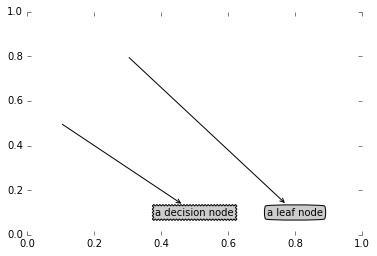

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")
#node类型用于设定注解文本的边框，arrow_args指明了箭头方向，朝左表示parentPt指向centerPt

#centerPt是注解的中心坐标，parentPt是线段另一端（常规意义上的“被注解处”）的坐标
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,
    xycoords='axes fraction',
    xytext=centerPt, textcoords='axes fraction',
    va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf() #清空当前figure
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

createPlot()

# 从原始数据画出决策树的过程

In [2]:
#原始数据
from math import log
import operator

#创建数据集（书上表3-1）
myDat = [[1, 1, 'yes'],
         [1, 1, 'yes'],
         [1, 0, 'no' ],
         [0, 1, 'no' ],
         [0, 1, 'no' ]]
featName = ['no surfacing','flippers'] #后面画图时才用到

#### 为什么要选用最后一列（label）来计算熵？
因为我们只关心最后一列，目标就是区分出鱼类和非鱼类。

In [3]:
#套公式计算熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet) #实例个数
    labelCounts = {}
    for featVec in dataSet: #对于每个实例
        currentLabel = featVec[-1] #其最后一列是label
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0 #如果没出现过，初始化为0
        labelCounts[currentLabel] += 1 #计数增1
    shannonEnt = 0.0
    for key in labelCounts: #对于每种label
        prob = float(labelCounts[key])/numEntries #计算概率（出现频率）
        shannonEnt -= prob * log(prob,2) #套用计算H的公式
    return shannonEnt

数据分类：按照某一列（axis）上的值是否等于value来分割，返回true的一组

In [4]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:]) #于是第axis列的值featVec[axis]被剔除了
            retDataSet.append(reducedFeatVec)
    return retDataSet

- 比如说有三个样本tempDat=[1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no']
- 参数为(tempDat, 0, 1)，表示我要求抽取第0列值为1的myDat的子集，所谓的reduce是指去除子集中原来的第0列
- 所以返回的retDataSet结果应当为[1, 'yes'], [0, 'no']

能使划分结果信息增量最大的特征选为最佳特征

In [5]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1 #特征个数
    baseEntropy = calcShannonEnt(dataSet) #原熵
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures): #依次处理每个特征
        featList = [example[i] for example in dataSet] #取得原始数据中的第i列
        uniqueVals = set(featList) #去掉其中重复值
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value) 
            #尽管splitDataSet的功能【只only】取符合条件（==value）的
            #【但是】value是会被遍历取的，所以假如分成了两组，那么两组都会被计算熵，然后乘权重求和(类似求期望的公式)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
            #举例来说，原始集合A有10个元素，分成了A1和A2两个子集，A1有3个元素，A2有7个
            #新的熵就是 3/10*Ent(A1)+7/10*Ent(A2)
        infoGain = baseEntropy - newEntropy
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i#选出信息增益最大的特征，给出去
    return bestFeature

有可能特征用光了但分类还没完全分好，所以再def一个投票函数应对这种情况

In [6]:
def majorityCnt(classList): #投票
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    #sortedClassCount = sorted(classCount.iteritems(), #这是Python2的写法
    sortedClassCount = sorted(classCount.items(), 
                              key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]
    #如果特征都消耗完了，但叶节点（对应着一个数据子集）中的标签还是不唯一，那么投票表决出这个叶节点分类的标签

具体创建树结构的方法

In [7]:
def createTree(dataSet,featName):
    classList = [example[-1] for example in dataSet] #取到所有的分类
    if classList.count(classList[0]) == len(classList): #如果列表中第0个元素的出现次数等于列表长度
        #也就是说classList中已经全是同类
        return classList[0]
    if len(dataSet[0]) == 1: #如果每个实例长度只剩1，表明特征已经全部消耗完了，每个实例都被reduce至只剩标签列
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = featName[bestFeat]#最佳特征
    myTree = {bestFeatLabel:{}}
    del(featName[bestFeat]) #消耗掉一个特征，从labels里清掉
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues) #可以参照chooseBestFeatureToSplit理解，很相似
    for value in uniqueVals:
        subLabels = featName[:] #字典结构，第零个元素是树（或子树）的根节点
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree
    
myTree = createTree(myDat,featName)

需要知道树的高度和叶节点个数，或者说树的大小（然后才能确定画板的大小）

In [8]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstSides = list(myTree.keys()) 
    firstStr = firstSides[0] #相当于获取myTree的根节点，值为应该放在根标签上的文本
    secondDict = myTree[firstStr] #myTree字典中第一个元素的“值”
    for key in secondDict.keys(): #
        if type(secondDict[key]).__name__=='dict': #如果仍然是嵌套的字典
            numLeafs += getNumLeafs(secondDict[key]) #递归求子树的叶节点数
        else: numLeafs +=1 #否则叶节点计数增1
    return numLeafs

def getTreeDepth(myTree): #参看getNumLeafs的注释
    maxDepth = 0
    firstSides = list(myTree.keys()) 
    firstStr = firstSides[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else: thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

看看叶节点和高度的计数结果是否正确

In [9]:
t0 = {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
t1 = {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
print(getNumLeafs(t1))
print(getTreeDepth(t1))

4
3


大脑已经停工了，这部分画图的具体细节我暂时略过。。。

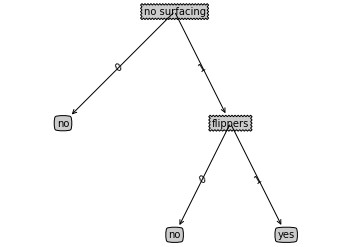

In [10]:
#放文字注释
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

#画树的预备工作
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstSides = list(myTree.keys()) 
    firstStr = firstSides[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

#画出图形来
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

createPlot(myTree)

#### 下面是实用的分类器
其中的for循环最好用 ```t0={'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}```来演想，不然理解起来有点难度

In [11]:
def classify(inputTree,featLabels,testVec): #testVec是一个待归类的实例
    firstSides = list(inputTree.keys()) 
    firstStr = firstSides[0] #即字典首个元素的“键”
    secondDict = inputTree[firstStr] #字典首个元素的“值”
    featIndex = featLabels.index(firstStr) #返回firstStr是原始数据中的第几个特征
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__=='dict':
                classLabel = classify(secondDict[key],featLabels,testVec)
            else: classLabel = secondDict[key]
    return classLabel

构造决策树是个比较耗时的过程，所以如果能在分类时调用已有的决策树往往能提高效率。下面用pickle序列化对象，可以把对象（字典也是对象）保存在磁盘上，需要时再读取出来。

In [12]:
def storeTree(inputTree,filename):
    import pickle
    fw = open(filename,'wb')
    pickle.dump(inputTree,fw)
    fw.close()

def grabTree(filename):
    import pickle
    fr = open(filename,'rb')
    return pickle.load(fr)

#上面两处open函数的第二个参数估计是指定存为二进制文件。不带b的话会报错，我不想细究这里。

In [13]:
storeTree(myTree,"classifierStorage.txt")

In [14]:
grabTree("classifierStorage.txt") #试试

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 实际操作：患者需要佩戴的隐形眼镜类型

In [15]:
fr=open('lenses.txt')
lenses=[inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels=['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses,lensesLabels)
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

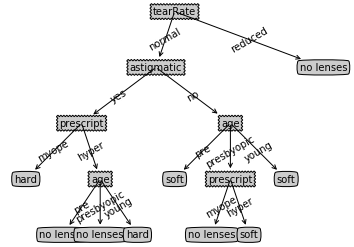

In [16]:
createPlot(lensesTree)